In [1]:
import os
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

random.seed("123")

In [2]:
split = "train"
base_path = "/home/manos/hdd/Binary_Datasets"
dataset_name = "Football"
base_dataset_path = f'{base_path}/{dataset_name}'
folder_path = f'{base_dataset_path}/{split}'
positive_letter = 'f'

In [3]:
# Get a list of all files in the folder
files = os.listdir(folder_path)

# Iterate over the files and perform action on files that start with 'F'
pos_files = []
neg_files = []
for file in files:
    if file.startswith(positive_letter) or file.startswith(str.upper(positive_letter)):
        pos_files.append(file)
    else:
        neg_files.append(file)

pos_counter = len(pos_files)
neg_counter = len(neg_files)
print(f'dataset positive files: {pos_counter}\n'
      f'dataset negative files: {neg_counter}')

dataset positive files: 40658
dataset negative files: 58302


## Check a negative and a positive image

name of image: N0008048.bmp


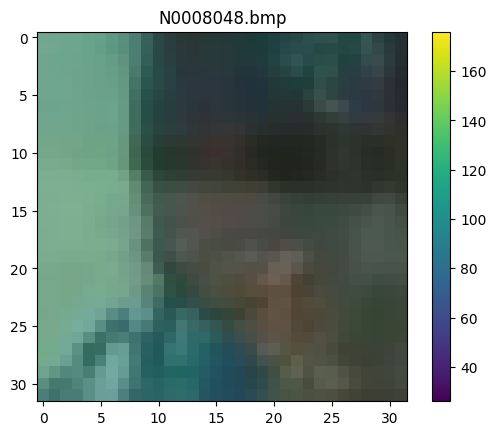

In [4]:
neg_image = plt.imread(os.path.join(folder_path,neg_files[0]))
plt.imshow(neg_image)
print(f'name of image: {neg_files[0]}')
plt.title(neg_files[0])
plt.colorbar()
plt.show()

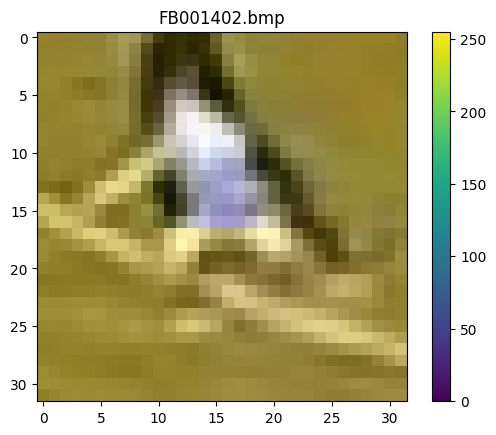

In [5]:
pos_image = plt.imread(os.path.join(folder_path,pos_files[0]))
plt.imshow(pos_image)
plt.title(pos_files[0])
plt.colorbar()
plt.show()

# Check the mean values

In [6]:
#read binary proto file with numpy
mean_values = np.fromfile(f"{base_dataset_path}/mean.binaryproto", dtype=np.float32)

print(np.shape(mean_values))
mean_values = mean_values[:-2]
print(np.shape(mean_values))
# reshape the mean_values array to match the shape of the image
mean_values = mean_values.reshape(neg_image.shape)
print(np.shape(mean_values))
print(mean_values)

(3074,)
(3072,)
(32, 32, 3)
[[[ 4.23189804e-37  1.35631461e-19  5.61251602e+01]
  [-1.53538289e-28 -4.53162023e-08  3.59032676e+21]
  [ 3.42401289e+15 -1.18794655e-02 -1.42993921e-37]
  ...
  [ 8.56029865e+14 -8.16376896e+08 -1.10639449e-11]
  [-1.03040693e-20  5.85716233e-34 -2.70113280e-15]
  [-3.57491053e-38  1.53541587e-28  2.57600118e-21]]

 [[-1.57907707e+34  5.60999948e+19 -2.24400771e+20]
  [ 7.42454780e-04 -9.59597905e-30 -6.75253977e-16]
  [ 2.63769823e-18  7.78514099e+02 -6.02347290e+28]
  ...
  [-1.13304663e-08  1.46438758e-34  1.08050936e-14]
  [-4.53192719e-08 -2.52661245e+35 -1.68825207e-16]
  [ 9.15194314e-36  3.76484794e+27  3.74854687e-32]]

 [[ 2.04088512e+08 -6.91474330e-13  1.43614005e+22]
  [ 7.78507812e+02  9.82616545e-27 -1.27550790e+07]
  [-2.24388685e+20 -1.72861996e-13  2.63767900e-18]
  ...
  [ 5.72197561e-37 -6.12376537e-39  4.98340352e+04]
  [-3.18922150e+06  5.22503373e+10 -7.08109849e-10]
  [ 6.14176604e-28  6.46793619e+37  5.99763878e-31]]

 ...

 [[ 2.

In [7]:
pos_image

array([[[150, 130,  44],
        [149, 128,  45],
        [146, 128,  46],
        ...,
        [151, 130,  39],
        [150, 130,  39],
        [143, 125,  41]],

       [[147, 129,  43],
        [147, 129,  45],
        [148, 130,  47],
        ...,
        [148, 127,  38],
        [147, 126,  37],
        [141, 123,  37]],

       [[150, 131,  45],
        [149, 131,  46],
        [149, 131,  47],
        ...,
        [147, 125,  39],
        [145, 124,  37],
        [143, 125,  38]],

       ...,

       [[155, 139,  51],
        [151, 135,  47],
        [147, 131,  43],
        ...,
        [135, 117,  42],
        [138, 120,  44],
        [138, 116,  41]],

       [[158, 142,  54],
        [157, 140,  53],
        [155, 139,  51],
        ...,
        [154, 136,  60],
        [150, 131,  55],
        [152, 130,  55]],

       [[143, 127,  39],
        [150, 134,  46],
        [154, 139,  49],
        ...,
        [154, 136,  60],
        [157, 139,  63],
        [160, 138,  63]]

In [8]:
print(f'max of mean values: {mean_values.max()} in pos {mean_values.argmax()}')
print(f'min of mean values: {mean_values.min()} in pos {mean_values.argmin()}')

max of mean values: 2.5920690282238314e+38 in pos 2382
min of mean values: -2.592727395239566e+38 in pos 2356


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


name of image: N0008048.bmp


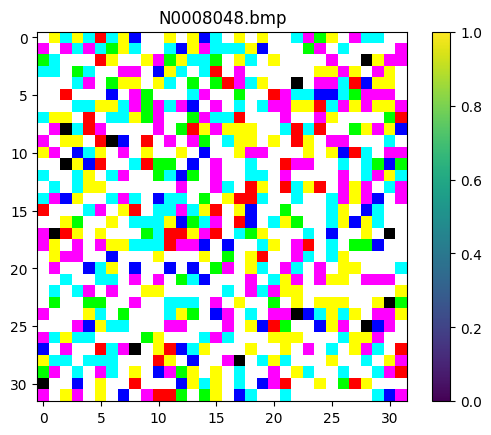

In [9]:
neg_image = plt.imread(os.path.join(folder_path,neg_files[0]))
plt.imshow(neg_image - mean_values)
print(f'name of image: {neg_files[0]}')
plt.title(neg_files[0])
plt.colorbar()
plt.show()

# Create simple dataset (white noice background with one random positive and else negatives in a 96X96 image)

In [10]:
def write_to_xml(image_name, bboxes, dabase_name, save_folder, xml_template='pascal_voc_template.xml'):
    # read xml file
    tree = ET.parse(xml_template)
    root = tree.getroot()

    # modify
    folder = root.find('folder')
    folder.text = 'Annotations'

    fname = root.find('filename')
    fname.text = image_name

    src = root.find('source')
    database = src.find('database')
    database.text = dabase_name

    h, w = bboxes[0][5]
    d = 3
    size = root.find('size')
    width = size.find('width')
    width.text = str(w)
    height = size.find('height')
    height.text = str(h)
    depth = size.find('depth')
    depth.text = str(d)

    for box in bboxes:
        # append object
        obj = ET.SubElement(root, 'object')

        name = ET.SubElement(obj, 'name')
        name.text = box[0]

        pose = ET.SubElement(obj, 'pose')
        pose.text = 'Unspecified'

        truncated = ET.SubElement(obj, 'truncated')
        truncated.text = str(0)

        difficult = ET.SubElement(obj, 'difficult')
        difficult.text = str(0)

        bndbox = ET.SubElement(obj, 'bndbox')

        xmin = ET.SubElement(bndbox, 'xmin')
        xmin.text = str(int(box[1]))

        ymin = ET.SubElement(bndbox, 'ymin')
        ymin.text = str(int(box[2]))

        xmax = ET.SubElement(bndbox, 'xmax')
        xmax.text = str(int(box[3]))

        ymax = ET.SubElement(bndbox, 'ymax')
        ymax.text = str(int(box[4]))

    # save .xml to anno_path
    anno_path = os.path.join(save_folder, "annotations", image_name.split('.')[0] + '.xml')
    tree.write(anno_path)

In [11]:
def calculate_iou(bbox1, bbox2):
    x1, y1, x2, y2 = bbox1
    x1_, y1_, x2_, y2_ = bbox2
    # Calculate the intersection coordinates
    xi1, yi1, xi2, yi2 = max(x1, x1_), max(y1, y1_), min(x2, x2_), min(y2, y2_)
    # Calculate the area of the intersection
    intersection_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    # Calculate the area of both bounding boxes
    bbox1_area = (x2 - x1) * (y2 - y1)
    bbox2_area = (x2_ - x1_) * (y2_ - y1_)
    # Calculate the union area
    union_area = bbox1_area + bbox2_area - intersection_area
    # Calculate the IoU
    iou = intersection_area / union_area
    return iou


def is_valid_bbox(bboxes_list, bbox, th):
    for i, box in enumerate(bboxes_list):
        iou = calculate_iou(bbox, box)
        if iou>th:
            return False
    return True


In [12]:
def random_crop(image, crop_size_ratio=0):
    width, height, ch = image.shape
    if isinstance(crop_size_ratio, tuple):
        crop_size_ratio_x = crop_size_ratio[0]
        crop_size_ratio_y = crop_size_ratio[1]
    else:
        crop_size_ratio_x = crop_size_ratio
        crop_size_ratio_y = crop_size_ratio
    if crop_size_ratio_x > 1 or crop_size_ratio_y > 1:
        raise ValueError("Crop size ratio should be smaller than 1")
    after_crop_pixels_y = random.randint(height - int(width*crop_size_ratio_y), height)
    after_crop_pixels_x = random.randint(width - int(width*crop_size_ratio_x), width)
    x = int(width/2)
    y = int(height/2)
    left = int(x - after_crop_pixels_x/2)
    right = int(left + after_crop_pixels_x)
    top = int(y - after_crop_pixels_y/2)
    bottom = int(top + after_crop_pixels_y)
    return image[left:right, top:bottom, :]

def random_stretch(image, stretch_ratio_th=(1, 1)):
    if isinstance(stretch_ratio_th[0], tuple):
        resize_ratio_th_x_neg = stretch_ratio_th[0][0]
        resize_ratio_th_x_pos = stretch_ratio_th[0][1]
        resize_ratio_th_y_neg = stretch_ratio_th[1][0]
        resize_ratio_th_y_pos = stretch_ratio_th[1][1]
    else:
        resize_ratio_th_x_neg = stretch_ratio_th[0]
        resize_ratio_th_x_pos = stretch_ratio_th[0]
        resize_ratio_th_y_neg = stretch_ratio_th[1]
        resize_ratio_th_y_pos = stretch_ratio_th[1]
    width, height, ch = image.shape
    stretch_ration_x = random.uniform(resize_ratio_th_x_neg, resize_ratio_th_x_pos)
    stretch_ration_y = random.uniform(resize_ratio_th_y_neg, resize_ratio_th_y_pos)
    new_dimensions = (int(height*stretch_ration_y), int(width*stretch_ration_x)) #C format
    return cv2.resize(image, dsize=new_dimensions, interpolation=cv2.INTER_LINEAR)

def resize(image, resize_ratio=1):
    width, height, ch = image.shape
    new_dimensions = (int(height*resize_ratio), int(width*resize_ratio)) #C format
    return cv2.resize(image, new_dimensions, interpolation=cv2.INTER_LINEAR)

def random_resize(image, resize_ratio_th=1):
    if isinstance(resize_ratio_th, tuple):
        resize_ratio_th_neg = resize_ratio_th[0]
        resize_ratio_th_pos = resize_ratio_th[1]
    else:
        resize_ratio_th_neg = resize_ratio_th
        resize_ratio_th_pos = resize_ratio_th
    resize_ratio = random.uniform(resize_ratio_th_neg, resize_ratio_th_pos)
    return resize(image, resize_ratio)

def random_pad(image, pad_th=0):
    pad = random.uniform(0, pad_th)
    width, height, ch = image.shape
    top = int(height*random.uniform(0, pad_th))
    bottom = int(height*random.uniform(0, pad_th))
    left = int(width*random.uniform(0, pad_th))
    right = int(width*random.uniform(0, pad_th))
    return cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_WRAP)

def random_rotate_image(images, image_pad, angle_th=0):
    if isinstance(angle_th, tuple):
        angle_th_neg = angle_th[0]
        angle_th_pos = angle_th[1]
    else:
        angle_th_neg = -angle_th
        angle_th_pos = angle_th
    # Generate a random angle between "angle_th_neg" and "angle_th_pos" degrees
    angle = random.uniform(angle_th_neg, angle_th_pos)
    new_images = []
    for image in images:
        # Calculate the dimensions needed to maintain the original size
        width, height, ch = image.shape

        cos_angle = np.abs(np.cos(np.radians(angle)))
        sin_angle = np.abs(np.sin(np.radians(angle)))
        new_w = int((height * sin_angle) + (width * cos_angle))
        new_h = int((height * cos_angle) + (width * sin_angle))

        center = (width // 2, height // 2)
        # Get the rotation matrix
        rotation_matrix = cv2.getRotationMatrix2D((center[1], center[0]), angle, 1.0)
        # Update the translation part of the rotation matrix to keep the new dimensions
        rotation_matrix[0, 2] += (new_h / 2) - center[1]
        rotation_matrix[1, 2] += (new_w / 2) - center[0]
        # Rotate the image
        new_images.append(cv2.warpAffine(image, rotation_matrix, (new_h, new_w), flags=cv2.INTER_LINEAR))
    return new_images

def random_flip(image, flip_th=0):
    if isinstance(flip_th, tuple):
        flip_vert = flip_th[0]
        flip_hor = flip_th[1]
    else:
        flip_vert = flip_th
        flip_hor = flip_th
    if random.random() < flip_hor:
        image = cv2.flip(image, 1)
    if random.random() < flip_vert:
        image = cv2.flip(image, 0)
    return image

def augmentations(image, flip_th=0, scale_th=1, stretch_th=(1, 1), crop_th=0, pad_th=0, angle_th=0):
    image = random_flip(image, flip_th)
    image = random_resize(image, scale_th)
    image = random_stretch(image, stretch_th)
    image = random_crop(image, crop_th)
    image_pad = random_pad(image, pad_th)
    images = random_rotate_image([image_pad, image], angle_th)
    return images[0], images[1]

In [13]:
split = "test"
base_path = "/home/manos/hdd/Binary_Datasets"
dataset_name = "Football"
base_dataset_path = f'{base_path}/{dataset_name}'
folder_path = f'{base_dataset_path}/{split}'
positive_letter = 'f'

In [14]:
# Get a list of all files in the folder
files = os.listdir(folder_path)

# Iterate over the files and perform action on files that start with 'F'
pos_files = []
neg_files = []
for file in files:
    if file.startswith(positive_letter) or file.startswith(str.upper(positive_letter)):
        pos_files.append(file)
    else:
        neg_files.append(file)

pos_counter = len(pos_files)
neg_counter = len(neg_files)
print(f'dataset positive files: {pos_counter}\n'
      f'dataset negative files: {neg_counter}')

dataset positive files: 4517
dataset negative files: 6478


In [15]:
# create an empty image with the desired shape (32, 32, 3)
image_size = (96, 96, 3)
background = np.zeros(image_size, dtype=np.uint8)

# # fill the image with random RGB values
# image[:, :, 0] = np.random.randint(0, 256, (32, 32)) # fill the Red channel with random values
# image[:, :, 1] = np.random.randint(0, 256, (32, 32)) # fill the Green channel with random values
# image[:, :, 2] = np.random.randint(0, 256, (32, 32)) # fill the Blue channel with random values

# add white noise to the image
noise = np.random.normal(0, 60, image_size)
background = background + noise

# clip the values to make sure they stay within the valid range (0-255)
background = np.clip(background, 0, 255).astype(np.uint8)

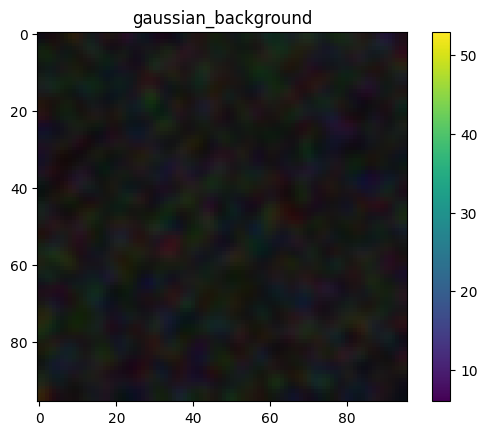

In [16]:
gaussian_background = cv2.GaussianBlur(background, (9, 9), 0)
plt.imshow(gaussian_background)
plt.title(f'gaussian_background')
plt.colorbar()
plt.show()

In [17]:
def update_mask(mask, new_position, mask_pixel_blur, new_image_shape, image_mask=None):
    if image_mask is not None:
        mask[image_mask[:,:,0]==0] = 0
        image_mask[image_mask>20] = 0
        image_mask[image_mask>0] = 1

        mask[image_mask[:,:,0]>0] = 255
        return mask
    plus_mask_boundaries_top_left = (new_position[0]-mask_pixel_blur if new_position[0]-mask_pixel_blur>0 else 0,
                                     new_position[0]+new_image_shape[0]+mask_pixel_blur
                                     if new_position[0]+new_image_shape[0]+mask_pixel_blur<new_image.shape[0] else new_image.shape[0])
    plus_mask_boundaries_bottom_right = (new_position[1]-mask_pixel_blur if new_position[1]-mask_pixel_blur>0 else 0,
                                         new_position[1]+new_image_shape[1]+mask_pixel_blur
                                         if new_position[1]+new_image_shape[1]+mask_pixel_blur<new_image.shape[1] else new_image.shape[1])

    mask[plus_mask_boundaries_top_left[0]:plus_mask_boundaries_top_left[1], plus_mask_boundaries_bottom_right[0]:plus_mask_boundaries_bottom_right[1], :] = 255
    mask[new_position[0]+mask_pixel_blur:new_position[0]+new_image_shape[0]-mask_pixel_blur, new_position[1]+mask_pixel_blur:new_position[1]+new_image_shape[1]-mask_pixel_blur, :] = 0
    return mask

In [18]:
def detect_only_image(image):
    new_mask = cv2.inRange(image, 0, 1)
    new_mask[new_mask>0] = 1
    prewitt_x = np.array([[-3, 0, 1],
                          [-3, 0, 1],
                          [-3, 0, 1]])
    prewitt_y = np.array([[-3, -3, -3],
                          [ 0,  0,  0],
                          [ 1,  1,  1]])
    prewitt_xy = np.array([[-1, -1,  0],
                           [-1,  0,  3],
                           [ 0,  3,  3]])
    prewitt_yx = np.array([[0, -3, -3],
                           [1,  0, -3],
                           [1,  1,  0]])
    # Apply Prewitt kernels
    edges_x = cv2.filter2D(new_mask, -1, prewitt_x)
    edges_y = cv2.filter2D(new_mask, -1, prewitt_y)
    edges_xy = cv2.filter2D(new_mask, -1, prewitt_xy)
    edges_yx = cv2.filter2D(new_mask, -1, prewitt_yx)
    edges_x2 = cv2.filter2D(new_mask, -1, -prewitt_x)
    edges_y2 = cv2.filter2D(new_mask, -1, -prewitt_y)
    edges_xy2 = cv2.filter2D(new_mask, -1, -prewitt_xy)
    edges_yx2 = cv2.filter2D(new_mask, -1, -prewitt_yx)
    # Combine the results
    edges = edges_x+edges_y+edges_xy+edges_yx+edges_xy2+edges_yx2+edges_x2+edges_y2
    edges = np.tile(edges[:, :, np.newaxis], (1, 1, 3))
    # edges[edges>0] = 1
    return edges

dataset_name: Football
bboxes :[['player', 1254, 862, 1296, 908, (1088, 1920)], ['player', 1371, 329, 1411, 368, (1088, 1920)], ['player', 1690, 407, 1731, 448, (1088, 1920)], ['player', 1858, 378, 1892, 415, (1088, 1920)], ['player', 439, 495, 478, 539, (1088, 1920)], ['player', 703, 311, 736, 351, (1088, 1920)], ['player', 197, 71, 248, 124, (1088, 1920)], ['player', 974, 773, 1030, 830, (1088, 1920)], ['player', 140, 982, 174, 1010, (1088, 1920)], ['player', 727, 417, 751, 453, (1088, 1920)], ['player', 1285, 309, 1332, 356, (1088, 1920)], ['player', 343, 207, 400, 262, (1088, 1920)], ['player', 1869, 794, 1908, 832, (1088, 1920)], ['player', 1353, 1018, 1390, 1065, (1088, 1920)], ['player', 1603, 837, 1629, 866, (1088, 1920)], ['player', 1203, 527, 1253, 582, (1088, 1920)], ['player', 879, 965, 923, 1019, (1088, 1920)], ['player', 881, 680, 916, 718, (1088, 1920)], ['player', 1292, 592, 1350, 642, (1088, 1920)], ['player', 918, 12, 949, 53, (1088, 1920)], ['player', 1778, 407, 1820

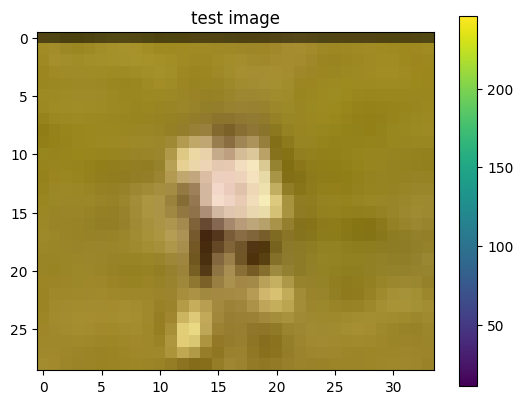

In [19]:
random.seed("123")
# Randomize image order
neg_idx = list(range(len(neg_files)))
pos_idx = list(range(len(pos_files)))
random.shuffle(neg_idx)
random.shuffle(pos_idx)

# size_of_new_image=(2, 2)
# number_of_pos_img = 3

size_of_new_image = (11.34, 20) # for 1088 * 1920
number_of_pos_img = 22         # for 1088 * 1920
new_image = background.copy()
new_image = random_stretch(new_image, size_of_new_image)

# new_image = resize(new_image, size_of_new_image)
image_size = new_image.shape

images = int((len(pos_idx)/number_of_pos_img))

mask_pixel_blur = 3
number_of_negs_width = int((3*size_of_new_image[0])+0.5) #Add code for random number of neg images
number_of_negs_height = int((3*size_of_new_image[1])+0.5)

image = 0
mask = np.zeros_like(new_image)
for width in range(number_of_negs_width):
    for height in range(number_of_negs_height):
        neg_image_idx = ((number_of_negs_height*width)+height+(image*number_of_negs_width*number_of_negs_height)) % neg_counter
        neg_image = plt.imread(os.path.join(folder_path,neg_files[neg_image_idx]))

        starting_pot = (width*neg_image.shape[0], height*neg_image.shape[1])
        neg_width = neg_image.shape[0] if starting_pot[0]+neg_image.shape[0] < new_image.shape[0] else new_image.shape[0]-starting_pot[0]
        neg_height = neg_image.shape[1] if starting_pot[1]+neg_image.shape[1] < new_image.shape[1] else new_image.shape[1]-starting_pot[1]
        mask = update_mask(mask, starting_pot, mask_pixel_blur//2, (neg_width, neg_width))
        new_image[starting_pot[0]:starting_pot[0]+neg_width, starting_pot[1]:starting_pot[1]+neg_height, :] = neg_image[:neg_width, :neg_height, :]

bboxes = []
bbox_padded = []
bboxes_list_padded = []
new_pos_image=np.zeros_like(new_image)
for pos_img in range(number_of_pos_img):
    pos_image_idx = pos_idx[image+(images*pos_img)] #Add code for random number of pos images
    pos_image = plt.imread(os.path.join(folder_path,pos_files[pos_image_idx]))
    temp_pos_image = np.zeros_like(new_pos_image)
    # pos_image_pad, pos_image = augmentations(pos_image, flip_th=(0, 1), scale_th=(0.9,2.0), stretch_th=((0.9, 1.2), (0.8, 1.1)),
    #                                          pad_th=0.1, crop_th=(0.1, 0.1), angle_th=5)
    pos_image_pad, pos_image = augmentations(pos_image, flip_th=(0, 0.5), scale_th=(1.0,1.0), stretch_th=((1.0, 1.0), (1.0, 1.0)),
                                             pad_th=0.3, crop_th=(0.0, 0.0), angle_th=0)
    position_of_pos = (random.randint(pos_image_pad.shape[0]//2,image_size[0]-int((pos_image_pad.shape[0]/2)+0.6)), random.randint(pos_image_pad.shape[1]//2,image_size[1]-int((pos_image_pad.shape[1]/2)+0.6)))
    bbox_padded = [position_of_pos[1]-(pos_image_pad.shape[1]//2), position_of_pos[0]-(pos_image_pad.shape[0]//2), position_of_pos[1]+int((pos_image_pad.shape[1]/2)+0.6), position_of_pos[0]+int((pos_image_pad.shape[0]/2)+0.6)]

    # find correct bbox to not overlap
    while not is_valid_bbox(bboxes_list_padded, bbox_padded, 0.15):
        position_of_pos = (random.randint(pos_image_pad.shape[0]//2,image_size[0]-int((pos_image_pad.shape[0]/2)+0.6)), random.randint(pos_image_pad.shape[1]//2,image_size[1]-int((pos_image_pad.shape[1]/2)+0.6)))
        bbox_padded = [position_of_pos[1]-(pos_image_pad.shape[1]//2), position_of_pos[0]-(pos_image_pad.shape[0]//2), position_of_pos[1]+int((pos_image_pad.shape[1]/2)+0.6), position_of_pos[0]+int((pos_image_pad.shape[0]/2)+0.6)]

    # save actual not padded bbox
    bbox = [position_of_pos[1]-(pos_image.shape[1]//2), position_of_pos[0]-(pos_image.shape[0]//2), position_of_pos[1]+int((pos_image.shape[1]/2)+0.6), position_of_pos[0]+int((pos_image.shape[0]/2)+0.6)]
    # save bbox for future overlap
    bboxes_list_padded.append(bbox_padded)
    # patch image
    temp_pos_image[bbox_padded[1]:bbox_padded[3], bbox_padded[0]:bbox_padded[2], :] = pos_image_pad
    pos_image_mask = detect_only_image(temp_pos_image)
    new_pos_image[pos_image_mask==0] = temp_pos_image[pos_image_mask==0]
    # save bbox for annotation function
    bboxes.append(["player", bbox[0], bbox[1], bbox[2], bbox[3], (image_size[0], image_size[1])])

    # border image mask to blue for seemingly be patch with the background
    # easier to make update_mask if is in top-left format and not center
    position_of_pos = (position_of_pos[0]-pos_image_pad.shape[0]//2, position_of_pos[1]-pos_image_pad.shape[1]//2)
    mask = update_mask(mask, position_of_pos, mask_pixel_blur//2, pos_image_pad.shape)#, image_mask=pos_image_mask)

new_image[new_pos_image>0] = new_pos_image[new_pos_image>0]
blurr_image = cv2.GaussianBlur(new_image, (mask_pixel_blur, mask_pixel_blur), 0)
new_image[mask>0]= blurr_image[mask>0]

print(f"dataset_name: {dataset_name}")
print(f"bboxes :{bboxes}")

plt.imshow(pos_image)
plt.title(f'test image')
plt.colorbar()
plt.show()

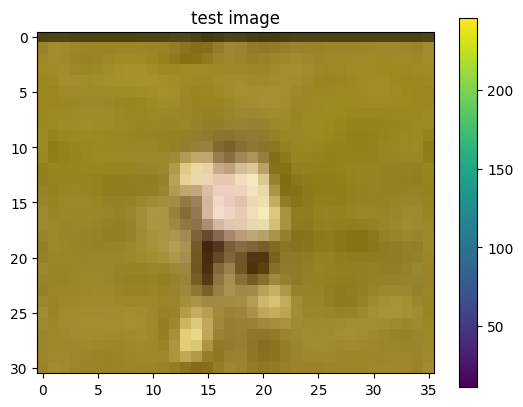

In [20]:
plt.imshow(pos_image_pad)
plt.title(f'test image')
plt.colorbar()
plt.show()

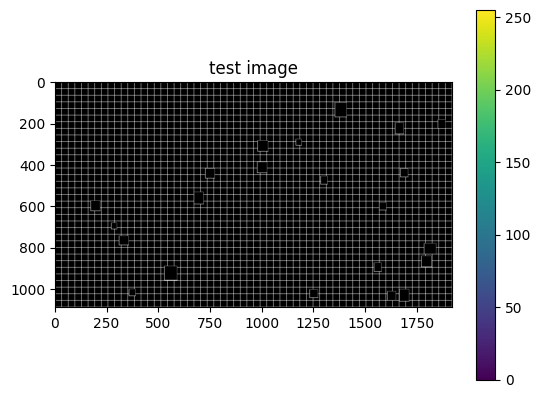

In [24]:
plt.imshow(mask)
plt.title(f'test image')
plt.colorbar()
plt.show()

In [55]:
split = "test"
base_path = "/home/manos/hdd/Binary_Datasets"
dataset_name = "Football"
base_dataset_path = f'{base_path}/{dataset_name}'
folder_path = f'{base_dataset_path}/{split}'
positive_letter = 'f'

# Get a list of all files in the folder
files = os.listdir(folder_path)

# Iterate over the files and perform action on files that start with 'F'
pos_files = []
neg_files = []
for file in files:
    if file.startswith(positive_letter) or file.startswith(str.upper(positive_letter)):
        pos_files.append(file)
    else:
        neg_files.append(file)

pos_counter = len(pos_files)
neg_counter = len(neg_files)
print(f'dataset positive files: {pos_counter}\n'
      f'dataset negative files: {neg_counter}')

dataset positive files: 4517
dataset negative files: 6478


In [56]:
name_prefix = "NEW"
random.seed("123")
# Randomize image order
neg_idx = list(range(len(neg_files)))
pos_idx = list(range(len(pos_files)))
random.shuffle(neg_idx)
random.shuffle(pos_idx)

# size_of_new_image=(2, 2)
# number_of_pos_img = 3

size_of_new_image = (11.34, 20) # for 1088 * 1920
number_of_pos_img = 22         # for 1088 * 1920
new_image = background.copy()
new_image = random_stretch(new_image, size_of_new_image)

# new_image = resize(new_image, size_of_new_image)
image_size = new_image.shape

images = int((len(pos_idx)/number_of_pos_img))

mask_pixel_blur = 3
number_of_negs_width = int((3*size_of_new_image[0])+0.5) #Add code for random number of neg images
number_of_negs_height = int((3*size_of_new_image[1])+0.5)

save_folder = f'{base_dataset_path}/{96*size_of_new_image[1]}x{96*size_of_new_image[0]}_{number_of_pos_img}pos_{number_of_negs_width*number_of_negs_height}neg_padded/{split}'
save_folder_eval = f'{base_dataset_path}/{96*size_of_new_image[1]}x{96*size_of_new_image[0]}_{number_of_pos_img}pos_{number_of_negs_width*number_of_negs_height}neg_padded/eval'
if not os.path.exists(save_folder):
    os.makedirs(f"{save_folder}/images")
    os.makedirs(f"{save_folder}/annotations")
if split == "test":
    eval_ratio = 0/10
else:
    eval_ratio = 1/10
    if not os.path.exists(save_folder_eval):
        os.makedirs(f"{save_folder_eval}/images")
        os.makedirs(f"{save_folder_eval}/annotations")

for image in range(0, images):
    mask = np.zeros_like(new_image)
    for width in range(number_of_negs_width):
        for height in range(number_of_negs_height):
            neg_image_idx = ((number_of_negs_height*width)+height+(image*number_of_negs_width*number_of_negs_height)) % neg_counter
            neg_image = plt.imread(os.path.join(folder_path,neg_files[neg_image_idx]))

            starting_pot = (width*neg_image.shape[0], height*neg_image.shape[1])
            neg_width = neg_image.shape[0] if starting_pot[0]+neg_image.shape[0] < new_image.shape[0] else new_image.shape[0]-starting_pot[0]
            neg_height = neg_image.shape[1] if starting_pot[1]+neg_image.shape[1] < new_image.shape[1] else new_image.shape[1]-starting_pot[1]
            mask = update_mask(mask, starting_pot, mask_pixel_blur//2, (neg_width, neg_width))
            new_image[starting_pot[0]:starting_pot[0]+neg_width, starting_pot[1]:starting_pot[1]+neg_height, :] = neg_image[:neg_width, :neg_height, :]

    bboxes = []
    bbox_padded = []
    bboxes_list_padded = []
    new_pos_image=np.zeros_like(new_image)
    for pos_img in range(number_of_pos_img):
        pos_image_idx = pos_idx[image+(images*pos_img)] #Add code for random number of pos images
        pos_image = plt.imread(os.path.join(folder_path,pos_files[pos_image_idx]))
        temp_pos_image = np.zeros_like(new_pos_image)
        # pos_image_pad, pos_image = augmentations(pos_image, flip_th=(0, 1), scale_th=(0.9,2.0), stretch_th=((0.9, 1.2), (0.8, 1.1)),
        #                                          pad_th=0.1, crop_th=(0.1, 0.1), angle_th=5)
        pos_image_pad, pos_image = augmentations(pos_image, flip_th=(0, 0.5), scale_th=(1.0,1.0), stretch_th=((1.0, 1.0), (1.0, 1.0)),
                                                 pad_th=0.3, crop_th=(0.0, 0.0), angle_th=0)
        position_of_pos = (random.randint(pos_image_pad.shape[0]//2,image_size[0]-int((pos_image_pad.shape[0]/2)+0.6)), random.randint(pos_image_pad.shape[1]//2,image_size[1]-int((pos_image_pad.shape[1]/2)+0.6)))
        bbox_padded = [position_of_pos[1]-(pos_image_pad.shape[1]//2), position_of_pos[0]-(pos_image_pad.shape[0]//2), position_of_pos[1]+int((pos_image_pad.shape[1]/2)+0.6), position_of_pos[0]+int((pos_image_pad.shape[0]/2)+0.6)]

        # find correct bbox to not overlap
        while not is_valid_bbox(bboxes_list_padded, bbox_padded, 0.15):
            position_of_pos = (random.randint(pos_image_pad.shape[0]//2,image_size[0]-int((pos_image_pad.shape[0]/2)+0.6)), random.randint(pos_image_pad.shape[1]//2,image_size[1]-int((pos_image_pad.shape[1]/2)+0.6)))
            bbox_padded = [position_of_pos[1]-(pos_image_pad.shape[1]//2), position_of_pos[0]-(pos_image_pad.shape[0]//2), position_of_pos[1]+int((pos_image_pad.shape[1]/2)+0.6), position_of_pos[0]+int((pos_image_pad.shape[0]/2)+0.6)]

        # save actual not padded bbox
        bbox = [position_of_pos[1]-(pos_image.shape[1]//2), position_of_pos[0]-(pos_image.shape[0]//2), position_of_pos[1]+int((pos_image.shape[1]/2)+0.6), position_of_pos[0]+int((pos_image.shape[0]/2)+0.6)]
        # save bbox for future overlap
        bboxes_list_padded.append(bbox_padded)
        # patch image
        temp_pos_image[bbox_padded[1]:bbox_padded[3], bbox_padded[0]:bbox_padded[2], :] = pos_image_pad
        pos_image_mask = detect_only_image(temp_pos_image)
        new_pos_image[pos_image_mask==0] = temp_pos_image[pos_image_mask==0]
        # save bbox for annotation function
        bboxes.append(["player", bbox[0], bbox[1], bbox[2], bbox[3], (image_size[0], image_size[1])])

        # border image mask to blue for seemingly be patch with the background
        # easier to make update_mask if is in top-left format and not center
        position_of_pos = (position_of_pos[0]-pos_image_pad.shape[0]//2, position_of_pos[1]-pos_image_pad.shape[1]//2)
        mask = update_mask(mask, position_of_pos, mask_pixel_blur//2, pos_image_pad.shape)#, image_mask=pos_image_mask)

    new_image[new_pos_image>0] = new_pos_image[new_pos_image>0]
    blurr_image = cv2.GaussianBlur(new_image, (mask_pixel_blur, mask_pixel_blur), 0)
    new_image[mask>0]= blurr_image[mask>0]

    image_name = f'{name_prefix}{image:05}.bmp'
    final_folder = save_folder_eval if (random.uniform(0, 1) < eval_ratio) else save_folder
    plt.imsave(f"{final_folder}/images/{image_name}", new_image)
    write_to_xml(image_name, bboxes, dataset_name, f"{final_folder}", xml_template='pascal_voc_template.xml')

In [29]:
import numpy as np
from PIL import Image
import os

# Define the path to the dataset
dataset_path = f'{base_dataset_path}/96x96_1pos_9neg_2/train/images'

# Initialize variables to store the sum of means and standard deviations for each channel
mean_sum = np.zeros(3)
std_sum = np.zeros(3)
num_images = 0

# Iterate over all images in the dataset
for subdir, dirs, files in os.walk(dataset_path):
    for file in files:
        # Load the image
        image = Image.open(os.path.join(subdir, file))

        # Convert the image to a numpy array
        image_np = np.array(image)

        # Calculate the mean and standard deviation for each channel
        mean_sum += np.mean(image_np, axis=(0, 1))
        std_sum += np.std(image_np, axis=(0, 1))

        # Increment the number of images
        num_images += 1


# Calculate the mean and standard deviation for each channel for the entire dataset
mean = mean_sum / num_images
std = std_sum / num_images

print(f'Mean: {mean}')
print(f'Std: {std}')

KeyboardInterrupt: 

In [11]:
orginal_image = plt.imread("./predefined_examples/000000000036.jpg")
print(f"height: {orginal_image.shape[0]}")
print(f"width: {orginal_image.shape[1]}")

height: 640
width: 481


In [15]:
height = 2*orginal_image.shape[0]#640#(int)(1088/2)
width = 2*orginal_image.shape[1]#640#(int)(1920/2)
image_size = (height, width, 3)
background = np.zeros(image_size, dtype=np.uint8)
new_image = background.copy()

In [16]:
new_image[height-orginal_image.shape[0]:, width-orginal_image.shape[1]:, :] = orginal_image

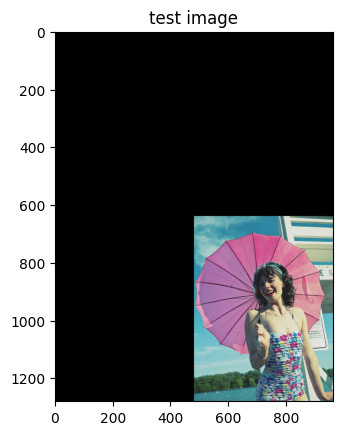

In [17]:
plt.imshow(new_image)
plt.title('test image')
plt.imsave("./predefined_examples/big_example3.jpg", new_image)